In [1]:
"""

TODO / Considerations:

IMPORTANT! Should I also include the full names here? If someone mentions the
stock by the company name instead of just the ticker.
Consideration that follows: we dont have to count appearances, maybe not for
the tickers as well?

Important consideration: right now, we only keep posts or comments that explicitly
mentions a ticker, and we might disregard any comments under a post discussing a
certain ticker that does not explicitly mention it. E.g.: "I really believe in
the leadership of this company and I think they will produce strong numbers in
the future" [obvious positive sentiment] under a post discussing "AAPL". FIX:
this can be fixed by finding the parent ID of a comment to see where it links.
Considerations here might be that we get higer ambiguity in these comments that
does not explicitly mention a ticker, but FinBERT should hopefully labels these
as "neutral".


"""

'\n\nTODO / Considerations:\n\nIMPORTANT! Should I also include the full names here? If someone mentions the\nstock by the company name instead of just the ticker.\nConsideration that follows: we dont have to count appearances, maybe not for\nthe tickers as well?\n\nImportant consideration: right now, we only keep posts or comments that explicitly\nmentions a ticker, and we might disregard any comments under a post discussing a\ncertain ticker that does not explicitly mention it. E.g.: "I really believe in\nthe leadership of this company and I think they will produce strong numbers in\nthe future" [obvious positive sentiment] under a post discussing "AAPL". FIX:\nthis can be fixed by finding the parent ID of a comment to see where it links.\nConsiderations here might be that we get higer ambiguity in these comments that\ndoes not explicitly mention a ticker, but FinBERT should hopefully labels these\nas "neutral".\n\n\n'

### **Financial Text Pre-Processing**

In [2]:
# Data retrieved from and credited to: https://github.com/ArthurHeitmann/arctic_shift

In [ ]:
from pathlib import Path

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    
    import importlib.util, subprocess, sys
    if importlib.util.find_spec("pandas_market_calendars") is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas_market_calendars"])


    DATA_PATH = Path("/content/data")
    
else: DATA_PATH = Path("../data").resolve()

DATA_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
# imports
import pyarrow as pa
import pyarrow.parquet as pq
import json
import re
from collections import Counter
from datetime import datetime, timezone, time
from json import JSONDecodeError
import duckdb
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_market_calendars as pmcal
import pytz
import os

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm


import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")

Running on cpu.


In [6]:
CLEANED_DATA_NAME = "cleaned_data"

PARQ_BATCH_SIZE = 50_000 # For smoother data storage in pre-processing

START_DATE = "2025-12-01" # Change later to an earlier one for more data.
END_DATE = "2026-02-03"

# Get the trading days and market opening hours for the NYSE
NYSE = pmcal.get_calendar("NYSE")
SCHEDULE = NYSE.schedule(
    start_date = START_DATE,
    end_date = END_DATE
)
TRADING_DAYS = pd.to_datetime(SCHEDULE.index.date)

NY_TZ = pytz.timezone("America/New_York")
MARKET_CLOSE = time(16, 0)

In [7]:
TICKERS = ["AAPL", "GOOGL", "MSFT", "META", "PLTR", "TSLA", "NVDA"] # maybe GME too?

SUBREDDITS = ["r_valueinvesting",
              "r_investing",
              "r_wallstreetbets",
              "r_stocks"
              ]

POST_TYPES = ["_posts", "_comments"]

In [8]:
def move_trading_day(date, trading_days):
    date = pd.to_datetime(date).date()
    future_days = trading_days[trading_days > pd.Timestamp(date)]
    return future_days[0].date()

# test for function, the 7th of december is not a trading day and should be moved
# to the 8th
# print(move_trading_day(datetime(2025,12,7), TRADING_DAYS))

In [ ]:
def raw_to_parquet(sub, pt, batch_size, data_path, data_folder_name, trading_days, extension_type=".jsonl"):
    data = []
    file_name = f"{sub}{pt}"
    pattern = re.compile(r"(?<![A-Z0-9])\$?(" + "|".join(TICKERS) + r")(?![A-Z0-9])", re.IGNORECASE)
    print("-"*50)
    print(f"Starting cleaning and saving for {file_name}...")
    try:
        file_ = Path(data_path, "reddit_dumps", file_name + extension_type)
        with open(file_, "r", encoding="utf-8") as f:
            bad_lines = 0
            total_lines = 0
            multi_tickers = 0
            for i, line in enumerate(f, start=1):
                # Make sure json loading works
                try:
                    total_lines += 1
                    line = json.loads(line)
                except JSONDecodeError as e:
                    print("Broken line index:", i)
                    print("Error:", e)
                    # print("Line:", line)
                    bad_lines += 1
                    continue

                # Make sure the post includes some text.
                title = line.get("title") or ""
                body = line.get("selftext") or line.get("body") or ""

                text = f"{title} {body}"

                ticker_matches = pattern.findall(text)
                if not ticker_matches:
                    continue

                # Move posts made outside trading days/hours to the next trading day.
                utc_formatted = datetime.fromtimestamp(line["created_utc"], tz=timezone.utc)
                ny_dt = utc_formatted.astimezone(NY_TZ)

                date = ny_dt.date()

                if pd.Timestamp(date) not in trading_days:
                    date = move_trading_day(date, trading_days)

                if ny_dt.time() >= MARKET_CLOSE:
                    date = move_trading_day(date, trading_days)

                tickers = sorted({m.upper() for m in ticker_matches})
                ticker_counts = Counter(m.upper() for m in ticker_matches)

                # we do not allow posts/comments mentioning more than one ticker
                if len(tickers) > 1:
                    multi_tickers += 1
                    continue

                # we do not want to consider posts by automoderators
                if line["author"] == "AutoModerator":
                    continue

                data.append({
                    "subreddit": sub,
                    "id": line["id"],
                    "author": line["author"],
                    "created_utc": line["created_utc"],
                    "year": date.year,
                    "month": date.month,
                    "day": date.day,
                    "trading_date": str(date),
                    "score": line["score"],
                    "title": title,
                    "text": body,
                    "ticker": tickers[0],
                    "ticker_counts": ticker_counts
                    })

                if len(data) >= batch_size:
                    # partition the data into batches when writing to parquet for RAM bounding
                    table = pa.Table.from_pylist(data)
                    pq.write_to_dataset(
                        table,
                        root_path=Path(data_path, data_folder_name),
                        partition_cols=["ticker", "year", "month"]
                    )
                    data.clear()

        # dump the remaining data, if there is any
        if len(data) > 0:
            print(f"Remaining cols: {len(data)}")
            table = pa.Table.from_pylist(data)
            pq.write_to_dataset(
                table,
                root_path=Path(data_path, data_folder_name),
                partition_cols=["ticker", "year", "month"] # we could also partition by ticker ??
            )
            data.clear()
    except OSError:
        print(f"Could not find the file {file_name}. No files created.")
        return

    print(f"Amount of multiticker posts/comments: {multi_tickers}, total: {total_lines}")
    print(f"Percentage of multi_tickers lines: {0 if total_lines == 0 else round(multi_tickers/total_lines, 2) * 100}%")
    print(f"Total lines: {total_lines}, total corrupt lines: {bad_lines}")
    print(f"Percentage of corrupt lines: {0 if total_lines == 0 else round(bad_lines/total_lines, 2) * 100}%")
    print(f"Data sucessfully saved to {Path(data_path, data_folder_name)}.")

In [ ]:
for sub in SUBREDDITS:
    for pt in POST_TYPES:
        # for easier formatting later on
        # aggregates both posts and comments into the same file
        raw_to_parquet(sub, pt, PARQ_BATCH_SIZE, DATA_PATH, CLEANED_DATA_NAME, TRADING_DAYS)

--------------------------------------------------
Starting cleaning and saving for r_valueinvesting_posts...
Remaining cols: 233
Amount of multiticker posts/comments: 78, total: 3871
Percentage of multi_tickers lines: 2.0%
Total lines: 3871, total corrupt lines: 0
Percentage of corrupt lines: 0.0%
Data sucessfully saved to C:\Users\arvid\Repos\degree_project\datar_valueinvesting.
--------------------------------------------------
Starting cleaning and saving for r_valueinvesting_comments...
Remaining cols: 3863
Amount of multiticker posts/comments: 547, total: 102959
Percentage of multi_tickers lines: 1.0%
Total lines: 102959, total corrupt lines: 0
Percentage of corrupt lines: 0.0%
Data sucessfully saved to C:\Users\arvid\Repos\degree_project\datar_valueinvesting.
--------------------------------------------------
Starting cleaning and saving for r_investing_posts...
Could not find the file r_investing_posts. No files created.
--------------------------------------------------
Starti

### **Time-Series Data Pre-Processing**

In [ ]:
# Time-series data retrieved from and credited to https://finance.yahoo.com (API)

In [25]:
def raw_to_timeseries(ticker, start_date, end_date):
    ticker_data = yf.Ticker(ticker)
    ticker_history = ticker_data.history(start=start_date, end=end_date)
    close_prices = ticker_history[["Close"]].reset_index().rename(columns={"Date": "date", "Close": "close"})
    close_prices["log_return"] = np.log(close_prices["close"] / close_prices["close"].shift(1))
    close_prices.loc[0, "log_return"] = 0
    close_prices["date"] = close_prices["date"].dt.date
    # print(close_prices)
    return close_prices

In [26]:
time_series_dict = {}
for ticker in TICKERS:
    time_series_dict[ticker] = raw_to_timeseries(ticker, START_DATE, END_DATE)

In [ ]:
# time_series_dict

### **Retrieve sentiment from posts and comments**

In [ ]:
# Use FinBERT (GIVE CREDITS HERE)

In [27]:
cleaned_data_path = Path(DATA_PATH, CLEANED_DATA_NAME, '**/*.parquet')
posts_data = duckdb.query(f"""
    SELECT *
    FROM read_parquet('{cleaned_data_path}')
""").df()

posts_data["full_text"] = posts_data["title"] + " " + posts_data["text"]

In [28]:
MODEL_TYPE = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_TYPE)
model.to(device).eval()

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

c:\Users\arvid\Repos\degree_project\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arvid\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [29]:
def text_to_sentiment(texts_list, batch_size=16, max_length=384):
    labels = []
    confs = []
    probs_all = []

    tqdm_iterable = [texts_list[i:i+batch_size] for i in range(0, len(texts_list), batch_size)]

    print(f"A total of {len(tqdm_iterable)} batches to process...")


    for batch in tqdm(tqdm_iterable):

        # Tokenize the input
        inputs = tokenizer(
            batch,
            padding = True,
            truncation = True,
            max_length = max_length, # max length, FinBERT has a token limit
            return_tensors = "pt"
        ).to(device)

        with torch.no_grad():
            logits = model(**inputs).logits
            probs = softmax(logits, dim=1)

        conf = probs.max(dim=1).values
        predicted_value = probs.argmax(dim=1)

        labels.extend(predicted_value.cpu().tolist())
        confs.extend(conf.cpu().tolist())
        probs_all.append(probs.cpu().numpy())

    probs_all = np.vstack(probs_all)
    return np.array(labels), np.array(confs), probs_all


In [ ]:
fin_texts = posts_data["full_text"].to_list()
# print(fin_texts)
labels, confs, probs = text_to_sentiment(fin_texts)

A total of 577 batches to process...


  0%|          | 0/577 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
id2label_dict = model.config.id2label
posts_data["sentiment_label"] = [id2label_dict[int(x)].lower() for x in labels]
posts_data["sentiment_conf"] = confs
posts_data["p_negative"] = probs[:, 0]
posts_data["p_neutral"] = probs[:, 1]
posts_data["p_positive"] = probs[:, 2]
posts_data["sentiment_value"] = posts_data["p_positive"] - posts_data["p_negative"] # assumption: neutral does not hold much information (?)

In [ ]:
# we do not need the title and text anymore since this data is already processed
posts_data = posts_data.drop(columns=["title", "text", "ticker_counts"])

In [ ]:
posts_data.columns

Index(['subreddit', 'id', 'author', 'created_utc', 'day', 'trading_date',
       'score', 'ticker_counts', 'month', 'ticker', 'year', 'full_text',
       'sentiment_label', 'sentiment_conf', 'p_negative', 'p_neutral',
       'p_positive', 'sentiment_value'],
      dtype='object')

In [ ]:
DATA_PATH

'/content/drive/MyDrive/KTH/Master, 4-5/ÅK2/Degree Project/data/'

In [ ]:
# dump data into a parquet file
posts_data.to_parquet(
    path=Path(DATA_PATH, "sentiment_parquet"),
    partition_cols=["ticker", "year", "month"]
)

In [ ]:
# alternatively, load data from parquet file
# posts_data = pd.read_parquet(Path(DATA_PATH, "sentiment_parquet"), engine="pyarrow")

<Axes: >

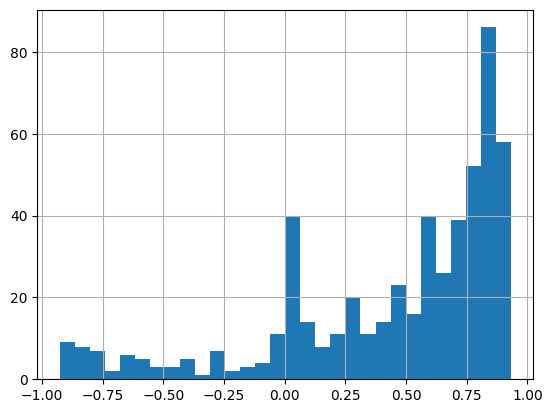

In [ ]:
# plot the sentiment distribution, higher => more positive and vice versa
posts_data["sentiment_value"].hist(bins=30)

### **Align sentiment data with log-return time-series data**

In [ ]:
sentiment_data_path = Path(DATA_PATH, 'sentiment_parquet/**/*.parquet')
posts_data = duckdb.query(f"""
    SELECT *
    FROM read_parquet('{sentiment_data_path}')
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:

all_rows = []
for ticker in TICKERS:
    rows = []
    ticker_data = duckdb.query(f"""
        SELECT *
        FROM read_parquet('{sentiment_data_path}')
        WHERE ticker = '{ticker}'
    """).df()
    for idx, row in time_series_dict[ticker].iterrows():
        # print(trading_date)
        trading_date = row["date"]
        log_return = row["log_return"]

        data = ticker_data.loc[(ticker_data["trading_date"].dt.date == trading_date)]
        # print(data.head())
        if data.empty:
            avg_sentiment = np.nan
        else:
            sentiments = data["sentiment_value"].to_numpy()
            scores = data["score"].to_numpy()

            negative_mask = scores < 0

            abs_scores = np.absolute(scores)
            log_scores = np.maximum(1.0, np.log1p(abs_scores))

            adj_sent = sentiments.copy()
            adj_sent[negative_mask] *= -1

            # weight sentiment by log of score and aggregate to average sentiment
            avg_sentiment = np.sum(log_scores * adj_sent)  / np.sum(log_scores)

        # print(avg_sentiment)

        rows.append({
            "date": trading_date,
            "ticker": ticker,
            "sentiment": avg_sentiment,
            "log_ret": log_return
        })

    all_rows.extend(rows)

aligned_data = pd.DataFrame(all_rows)
aligned_data.to_parquet(
    path=Path(DATA_PATH, "aligned_parquet"),
    partition_cols=["ticker"]
)

In [ ]:
aligned_data_path = Path(DATA_PATH, 'aligned_parquet/**/*.parquet')
aapl_data = duckdb.query(f"""
    SELECT *
    FROM read_parquet('{aligned_data_path}')
    WHERE ticker = 'AAPL'
""").df()

# print(aapl_data)

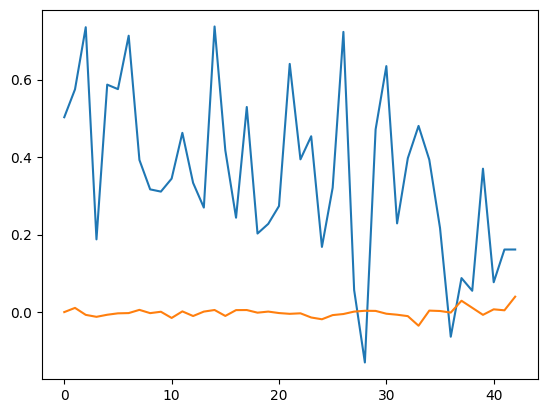

In [ ]:
plt.plot(aapl_data["sentiment"])
plt.plot(aapl_data["log_ret"])
plt.show()